In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import sys
sys.path.insert(0,"../src/")
#sys.path.insert(0,"../src_fork/analysis")

import linear_regression
import utils
import stat_tools
import crossvalidation
import bootstrap
from FrankeFunction import FrankeFunction


utils.plot_settings()  # LaTeX fonts in Plots!

FIGPATH = "../figs/"
FIGURESIZE= np.array([4,3]) # Good default figure size for tex documents

SEEDVAL = 2021

In [2]:
np.random.seed(SEEDVAL)
n = 500
noise_scale = 0.2
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
z = FrankeFunction(x, y)
# Adding standard normal noise:
z = z + noise_scale * np.random.normal(0, 1, len(z))
max_degree = 15
n_lambdas = 30
n_bootstraps = 100
k_folds = 5
lambdas = np.logspace(-5, 0, n_lambdas)
subset_lambdas = lambdas[::60]

x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2)

#   Centering the response
z_intercept = np.mean(z)
z = z - z_intercept

#   Centering the response
z_train_intercept = np.mean(z_train)
z_train = z_train - z_train_intercept
z_test = z_test - z_train_intercept

########### Setup of problem is completed above.

# Quantities of interest: note the indexing, element 0 is polynomial degree 1
mse_ols_test = np.zeros(max_degree)
mse_ols_train = np.zeros(max_degree)
ols_cv_mse = np.zeros(max_degree)

ols_boot_mse = np.zeros(max_degree)
ols_boot_bias = np.zeros(max_degree)
ols_boot_variance = np.zeros(max_degree)

best_ridge_lambda = np.zeros(max_degree)
best_ridge_mse = np.zeros(max_degree)
ridge_best_lambda_boot_mse = np.zeros(max_degree)
ridge_best_lambda_boot_bias = np.zeros(max_degree)
ridge_best_lambda_boot_variance = np.zeros(max_degree)

best_lasso_lambda = np.zeros(max_degree)
best_lasso_mse = np.zeros(max_degree)
lasso_best_lambda_boot_mse = np.zeros(max_degree)
lasso_best_lambda_boot_bias = np.zeros(max_degree)
lasso_best_lambda_boot_variance = np.zeros(max_degree)

ridge_lamb_deg_mse = np.zeros((max_degree, n_lambdas))
lasso_lamb_deg_mse = np.zeros((max_degree, n_lambdas))

ridge_subset_lambda_boot_mse = np.zeros((max_degree, len(subset_lambdas)))
ridge_subset_lambda_boot_bias = np.zeros((max_degree, len(subset_lambdas)))
ridge_subset_lambda_boot_variance = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_mse = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_bias = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_variance = np.zeros((max_degree, len(subset_lambdas)))

# Actual computations
for degree_index in range(max_degree):
    degree = degree_index + 1 # Little sense in doing stuff for 0 degrees.
    X = linear_regression.design_matrix_2D(x, y, degree)
    X_train = linear_regression.design_matrix_2D(x_train, y_train, degree)
    X_test = linear_regression.design_matrix_2D(x_test, y_test, degree)
    # Scaling and feeding to CV.
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled = X_scaled[:,1:]
    #    X_scaled[:,0] = 1 # Maybe not for ridge+lasso. Don't want to penalize constants...

    # Scaling and feeding to bootstrap and OLS
    scaler_boot = StandardScaler()
    scaler_boot.fit(X_train)
    X_train_scaled = scaler_boot.transform(X_train)
    X_test_scaled = scaler_boot.transform(X_test)
    X_train_scaled = X_train_scaled[:,1:]
    X_test_scaled = X_test_scaled[:,1:]
    #    X_train_scaled[:,0] = 1 #maybe not for ridge+lasso
    #    X_test_scaled[:,0] = 1 #maybe not for ridge+lasso

    # OLS, get MSE for test and train set.

    betas = linear_regression.OLS_SVD_2D(X_train_scaled, z_train)
    z_test_model = X_test_scaled @ betas
    z_train_model = X_train_scaled @ betas
    mse_ols_train[degree_index] = stat_tools.MSE(z_train, z_train_model)
    mse_ols_test[degree_index] = stat_tools.MSE(z_test, z_test_model)

    # CV, find best lambdas and get mse vs lambda for given degree. Also, gets
    # ols_CV_MSE

    lasso_cv_mse, ridge_cv_mse, ols_cv_mse_deg = crossvalidation.k_fold_cv_all(
        X_scaled, z, n_lambdas, lambdas, k_folds
    )
    best_lasso_lambda[degree_index] = lambdas[np.argmin(lasso_cv_mse)]
    best_ridge_lambda[degree_index] = lambdas[np.argmin(ridge_cv_mse)]
    best_lasso_mse[degree_index] = np.min(lasso_cv_mse)
    best_ridge_mse[degree_index] = np.min(ridge_cv_mse)
    lasso_lamb_deg_mse[degree_index] = lasso_cv_mse
    ridge_lamb_deg_mse[degree_index] = ridge_cv_mse
    ols_cv_mse[degree_index] = ols_cv_mse_deg

    # All regression bootstraps at once
    lamb_ridge = best_ridge_lambda[degree_index]
    lamb_lasso = best_lasso_lambda[degree_index]

    (
        ridge_mse,
        ridge_bias,
        ridge_variance,
        lasso_mse,
        lasso_bias,
        lasso_variance,
        ols_mse,
        ols_bias,
        ols_variance,
    ) = bootstrap.bootstrap_all(
        X_train_scaled, X_test_scaled, z_train, z_test, n_bootstraps, lamb_lasso, lamb_ridge
    )

    (
        ridge_best_lambda_boot_mse[degree_index],
        ridge_best_lambda_boot_bias[degree_index],
        ridge_best_lambda_boot_variance[degree_index],
    ) = (ridge_mse, ridge_bias, ridge_variance)

    (
        lasso_best_lambda_boot_mse[degree_index],
        lasso_best_lambda_boot_bias[degree_index],
        lasso_best_lambda_boot_variance[degree_index],
    ) = (lasso_mse, lasso_bias, lasso_variance)

    ols_boot_mse[degree_index], ols_boot_bias[degree_index], ols_boot_variance[degree_index] = (
        ols_mse,
        ols_bias,
        ols_variance,
    )

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.001839706192941, tolerance: 0.004455444394051063
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.277666391286582, tolerance: 0.004567172690415966
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.876812986004834, tolerance: 0.004216854012732998
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.546227713759766, tolerance: 0.004431192749463325
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.335116982350407, tolerance: 0.004654584538725579
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.970694710261713, tolerance: 0.004552071366275885
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.589904037690697, tolerance: 0.0038416339573927845
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.299767149501822, tolerance: 0.004184285884239671
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.125471365945055, tolerance: 0.004298862813202468
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3118192489417968, tolerance: 0.004423495654252942
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2163917868666818, tolerance: 0.004238039007135161
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2653184631834389, tolerance: 0.004452628722306348
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.779511041144293, tolerance: 0.005145835910559256
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.890688603177778, tolerance: 0.004105188298186424
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.450601479447657, tolerance: 0.004104584623219331
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.053329946604624, tolerance: 0.0038192118365347884
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.614424882828608, tolerance: 0.004230304846202721
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.999887420730724, tolerance: 0.004271463514219142
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7672251250422653, tolerance: 0.004224642390307668
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9898340418387228, tolerance: 0.004706349772806014
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.977362479101231, tolerance: 0.004285497807554294
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.597912387370476, tolerance: 0.0043757823533735665
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.331279909905604, tolerance: 0.004717990254721879
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.62271833642619, tolerance: 0.005759300651711913
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.123568976823357, tolerance: 0.004889197881077501
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.700351254018545, tolerance: 0.004585764799252658
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.34793589147058, tolerance: 0.0044212216006891585
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.08064933032801, tolerance: 0.004409853512719925
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.443664000299085, tolerance: 0.004147900615025486
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.783863881922635, tolerance: 0.004663520507383054
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0485009484638415, tolerance: 0.004409853512719925
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0833456322401087, tolerance: 0.004147900615025486
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.197495702940703, tolerance: 0.004663520507383054
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.099233314246913, tolerance: 0.004780305639793241
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.187781542977326, tolerance: 0.004540259197317553
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.322454536615439, tolerance: 0.0047021078160019505
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.797338344818446, tolerance: 0.005141305250107938
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.306912001276366, tolerance: 0.004586567017222318
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.497510887756851, tolerance: 0.0049336027784295895
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.59174424925375, tolerance: 0.0049262178975173435
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.710507199813877, tolerance: 0.004684270646385439
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.016911951529757, tolerance: 0.004860220737119256
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.791089672603361, tolerance: 0.0044389111318597525
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.242895716345688, tolerance: 0.004233529565860948
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.0138623963704205, tolerance: 0.004469003336776177
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2834209623316593, tolerance: 0.004233529565860948
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5616487212553114, tolerance: 0.004469003336776177
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3140440595980625, tolerance: 0.00438861433701058
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.756681818846488, tolerance: 0.003969376550927438
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.006046239734796, tolerance: 0.004212741736731288
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.416383357880763, tolerance: 0.004562898438771766
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.025088348641344, tolerance: 0.00428172243955213
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.872828078342458, tolerance: 0.004494396538786211
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.522638694496217, tolerance: 0.004121372978262416
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.04349773461684, tolerance: 0.004093085307667197
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.943758077725216, tolerance: 0.0053185277434292955
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.656786321036696, tolerance: 0.004712482079975432
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5172430264754855, tolerance: 0.004712482079975432
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7040898868939998, tolerance: 0.004264400766181028
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2501282149411512, tolerance: 0.004174560848971802
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.418331240999006, tolerance: 0.004447015447962552
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.444751480752098, tolerance: 0.00453324553712878
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.21373186752821, tolerance: 0.004729187493492685
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_de

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.495175787586652, tolerance: 0.004798196180721786
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.695373070379336, tolerance: 0.0054059320751939895
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.430601547284278, tolerance: 0.0041938830445094125
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.188346358602602, tolerance: 0.004365688365454385
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.163158933448766, tolerance: 0.004463175703316952
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6475800092743675, tolerance: 0.004791308221946987
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.89324960173649, tolerance: 0.004773669083100224
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.410235829752561, tolerance: 0.004630618111298235
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.284721088706377, tolerance: 0.00466490438083804
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_de

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.341236325999885, tolerance: 0.004291187327180606
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.186296438148553, tolerance: 0.004323155833997568
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.600421886090513, tolerance: 0.004624227688844155
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.342672280510312, tolerance: 0.004408085944071704
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.7539623310776005, tolerance: 0.004404844773032255
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6617112553019053, tolerance: 0.0037812655318333784
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.590459910384325, tolerance: 0.004886055287869114
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.569199435924512, tolerance: 0.0038958174288846567
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.118587229825822, tolerance: 0.004712356603044343
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.896331574830599, tolerance: 0.004734459605584308
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.424885979747362, tolerance: 0.004751973580903546
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.7363281674968825, tolerance: 0.004805625500494675
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.842520249180728, tolerance: 0.004348049516861942
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.4314549638219125, tolerance: 0.004460894002067267
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.468660175001418, tolerance: 0.0043688042967637165
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005363585288044703, tolerance: 0.004287247742084573
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.999270701908584, tolerance: 0.004256995766113804
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.457266853341822, tolerance: 0.004153414817265583
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.05714838480445, tolerance: 0.004069455107714363
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.521568713968811, tolerance: 0.004710894130515638
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.044128500513788, tolerance: 0.004547451984145046
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.293203282112293, tolerance: 0.005194930112484014
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.20653596965276, tolerance: 0.004409277060101859
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.1404012831240085, tolerance: 0.0038521572886263105
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.959689917649095, tolerance: 0.004606772294032286
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.486068903445446, tolerance: 0.004468168058504401
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.149121104760896, tolerance: 0.004280472632703331
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0355680074933176, tolerance: 0.004606772294032286
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9960675430651218, tolerance: 0.004468168058504401
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6721873126807214, tolerance: 0.004280472632703331
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.788911608742064, tolerance: 0.004273424726510669
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.998639224946929, tolerance: 0.004424262424703639
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.25068172952548, tolerance: 0.004141607069314945
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.143833270095332, tolerance: 0.004949643568776165
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.868136764401955, tolerance: 0.0046447824876708335
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.896909406560959, tolerance: 0.004265912599362238
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.157969999281963, tolerance: 0.004282916938087526
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.371237556677169, tolerance: 0.004366100190413614
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.613648691662736, tolerance: 0.004203082364697056
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.9308632104070265, tolerance: 0.004099661573030455
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.096618373237428, tolerance: 0.004229656740360843
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.14692521984043, tolerance: 0.004510412690070976
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.971069083512934, tolerance: 0.0042797746273813735
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.410453147700536, tolerance: 0.004451521638249486
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.40844140508793, tolerance: 0.004386948484267541
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.083480158134032, tolerance: 0.0042797746273813735
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5708925531567939, tolerance: 0.004451521638249486
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0421267720851386, tolerance: 0.004386948484267541
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.878753462972699, tolerance: 0.0044977365012244105
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.652033062491574, tolerance: 0.0038639772430590384
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.297429332583603, tolerance: 0.0048526145974135005
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.094481564801626, tolerance: 0.004657530000722901
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.835887056381645, tolerance: 0.004139487659036839
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.136874493519246, tolerance: 0.004242204071493884
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.254000221084466, tolerance: 0.004677077144294366
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.225638544353226, tolerance: 0.00433805258249224
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.151915982103647, tolerance: 0.0043034743197430956
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.591772800132227, tolerance: 0.0049145589768188605
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3612418168005043, tolerance: 0.004523884224384724
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6818621510564427, tolerance: 0.004038359685268624
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.262393233184929, tolerance: 0.004198303913396562
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.456629562720583, tolerance: 0.004544043831600545
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.071460185544895, tolerance: 0.0043497013720751555
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1912026754631171, tolerance: 0.004544043831600545
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10498822463434365, tolerance: 0.0043497013720751555
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05241529624943553, tolerance: 0.004419832636250442
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.668965419474862, tolerance: 0.004611525777626183
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.709387045852963, tolerance: 0.004911807355063499
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.080964166951202, tolerance: 0.004105242957145357
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.708206075190585, tolerance: 0.004670892247910744
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.366133797027299, tolerance: 0.00412509430219165
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.288929399910705, tolerance: 0.004227919255674394
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.075269042090266, tolerance: 0.004506980571241115
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.960947185098494, tolerance: 0.0043805489170401215
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.865739623545073, tolerance: 0.004271608247616578
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.698669427511148, tolerance: 0.0043805489170401215
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.511634170782919, tolerance: 0.004271608247616578
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.015710598434224, tolerance: 0.004362578602535833
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0185739543958654, tolerance: 0.004362578602535833
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014625685603771643, tolerance: 0.004392323762515286
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.047882952330322, tolerance: 0.004627236083239133
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordin

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.646751185183264, tolerance: 0.005299189030785602
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.4517461377389225, tolerance: 0.004503845456218057
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.223396524479178, tolerance: 0.004061499092542257
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.424765735503938, tolerance: 0.004882879374501287
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.174163888369916, tolerance: 0.0042062108273284975
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.2316490296863, tolerance: 0.004867481862446039
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.0341263450004305, tolerance: 0.004065544135981843
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.995928470572574, tolerance: 0.0043735944357049476
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.953286467497743, tolerance: 0.0044473572344722115
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.017956650213578, tolerance: 0.0043735944357049476
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.827480606090005, tolerance: 0.0044473572344722115
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.855628814674169, tolerance: 0.004132135885726696
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011231204585772758, tolerance: 0.004548298510232828
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.081067351573312, tolerance: 0.004241877852373609
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.751852087855438, tolerance: 0.004703766259227813
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.338885402336377, tolerance: 0.0046010641126912125
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.664302888463185, tolerance: 0.005544359916847335
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.196070481038289, tolerance: 0.004827676289756063
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0210224280196725, tolerance: 0.004756991740384194
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.508000230894515, tolerance: 0.004699101283879706
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3687869058969904, tolerance: 0.004635840169474156
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

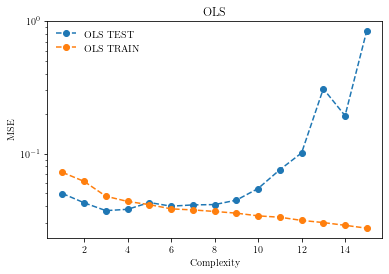

In [3]:
degrees = np.arange(1,max_degree+1)

plt.semilogy(degrees, mse_ols_test, "o--", label = "OLS TEST")
plt.semilogy(degrees, mse_ols_train, "o--", label = "OLS TRAIN")
plt.title("OLS")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend(frameon=False)
plt.savefig(FIGPATH + "OLS_MSE_Bootstrap_Hastie_211_N_{n}.pdf")

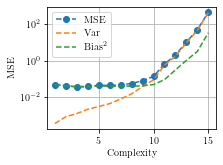

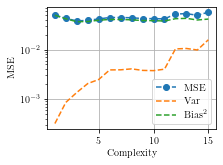

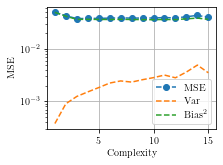

In [4]:
## BOOTSTRAP PLOTS
plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degrees, ols_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, ols_boot_variance,"--", label="Var")
plt.semilogy(degrees, ols_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.tight_layout()
#plt.ylim([1e-4, 2e-1])
plt.legend()
plt.grid()
plt.savefig(FIGPATH+f"Franke_OLS_bootstrap_N_{n}.pdf")

plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degrees, ridge_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, ridge_best_lambda_boot_variance,"--", label="Var")
plt.semilogy(degrees, ridge_best_lambda_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
#plt.ylim([1e-4, 2e-1])
plt.tight_layout()
plt.legend()
plt.grid()
plt.savefig(FIGPATH+f"Franke_Ridge_bootstrap_N_{n}.pdf")

plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degrees, lasso_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, lasso_best_lambda_boot_variance,"--", label="Var")
plt.semilogy(degrees, lasso_best_lambda_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
#plt.ylim([1e-4, 2e-1])
plt.legend()
plt.tight_layout()
plt.grid()
plt.savefig(FIGPATH+f"Franke_LASSO_bootstrap_N_{n}.pdf")

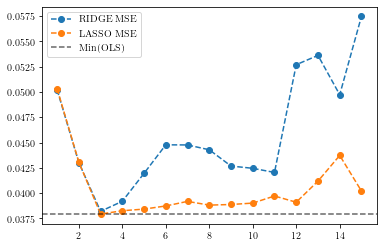

In [5]:
#plt.semilogy(degrees, ols_boot_mse,"o--",label="OLS MSE")
plt.plot(degrees, ridge_best_lambda_boot_mse,"o--",label="RIDGE MSE")
plt.plot(degrees, lasso_best_lambda_boot_mse,"o--",label="LASSO MSE")
plt.axhline(np.min(lasso_best_lambda_boot_mse), color="black", alpha=0.6, ls="--", label="Min(OLS)")

plt.legend()

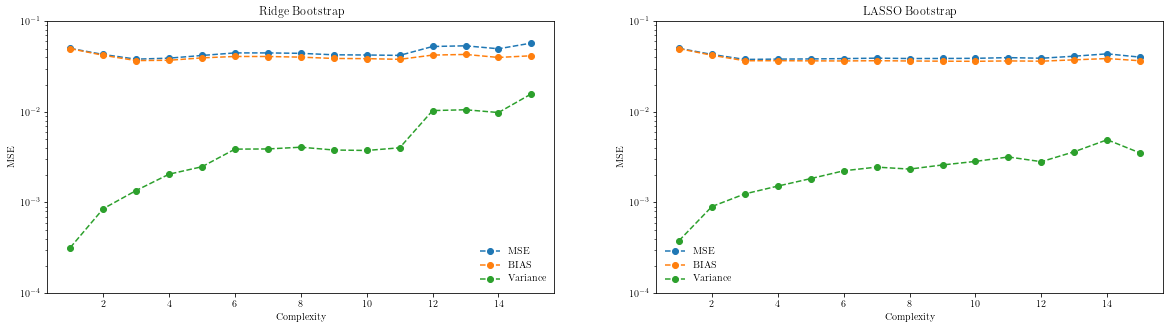

In [6]:
# Same bootstrap plots, but only better resolved LASSO & Ridge
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.semilogy(degrees, ridge_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, ridge_best_lambda_boot_bias,"o--", label="BIAS")
plt.semilogy(degrees, ridge_best_lambda_boot_variance,"o--", label="Variance")
plt.title("Ridge Bootstrap")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 1e-1])
plt.legend(frameon=False)

plt.subplot(122)
plt.semilogy(degrees, lasso_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, lasso_best_lambda_boot_bias,"o--", label="BIAS")
plt.semilogy(degrees, lasso_best_lambda_boot_variance,"o--", label="Variance")
plt.title("LASSO Bootstrap")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 1e-1])
plt.legend(frameon=False)
plt.show()

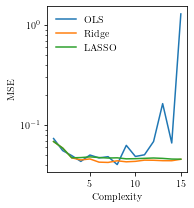

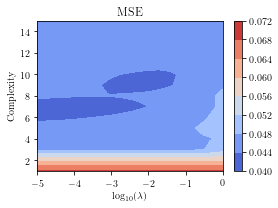

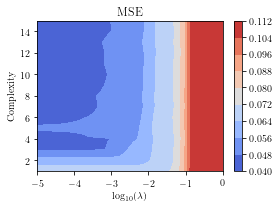

In [7]:
# CONTOUR PLOTS

plt.figure(figsize=FIGURESIZE*np.array([0.7, 1]))
#plt.axvline(degrees[np.argmin(ols_cv_mse)], ls="--", color="black", alpha=0.6)
plt.semilogy(degrees, ols_cv_mse, label="OLS")
plt.semilogy(degrees, best_ridge_mse, label="Ridge")
plt.semilogy(degrees, best_lasso_mse, label="LASSO")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend(loc="best", frameon=False)
plt.tight_layout()
plt.savefig(FIGPATH + f"OLS_CV_Franke_N_{n}.pdf")

# RIDGE
plt.figure(figsize=(4, 3) * np.array([1,1]))
X, Y = np.meshgrid(np.log10(lambdas), degrees)
plt.contourf(X, Y, ridge_lamb_deg_mse, cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel("$\\log_{10}(\lambda)$")
plt.ylabel("Complexity")
plt.title("MSE")
plt.tight_layout()
plt.savefig(FIGPATH + f"RIDGE_CV_Franke_contour_N_{n}.pdf")

# LASSO
plt.figure(figsize=(4, 3))
X, Y = np.meshgrid(np.log10(lambdas), degrees)
plt.contourf(X, Y, lasso_lamb_deg_mse, cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel("$\\log_{10}(\lambda)$")
plt.ylabel("Complexity")
plt.title("MSE")
plt.tight_layout()
plt.savefig(FIGPATH + f"LASSO_CV_Franke_contour_N_{n}.pdf")

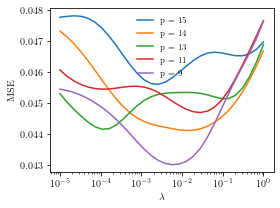

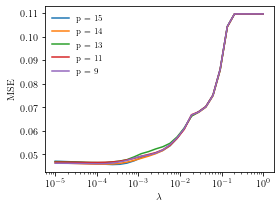

In [8]:
plt.figure(figsize=FIGURESIZE)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 1],
    label="p = {}".format(max_degree),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 2],
    label="p = {}".format(max_degree - 1),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 3],
    label="p = {}".format(max_degree - 2),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 5],
    label="p = {}".format(max_degree - 4),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 7],
    label="p = {}".format(max_degree - 6),
)
plt.xlabel("$\\lambda$")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(frameon=False, fontsize="small", loc='best')
plt.savefig(FIGPATH+f"RIDGE_best_lambda_FRANKE_N_{n}.pdf")

# For a copule of degrees, plot cv mse vs lambda for lasso, will break program if max_degree < 8.

plt.figure(figsize=FIGURESIZE)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 1],
    label="p = {}".format(max_degree),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 2],
    label="p = {}".format(max_degree - 1),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 3],
    label="p = {}".format(max_degree - 2),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 5],
    label="p = {}".format(max_degree - 4),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 7],
    label="p = {}".format(max_degree - 6),
)

plt.xlabel("$\\lambda$")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(frameon=False, fontsize="small", loc='best')
plt.savefig(FIGPATH+f"LASSO_best_lambda_FRANKE_N_{n}.pdf")

In [9]:
print(best_ridge_lambda)
print(best_lasso_lambda)

[1.00000000e+00 1.00000000e+00 2.80721620e-02 1.74332882e-03
 5.29831691e-04 1.00000000e-05 7.27895384e-05 5.29831691e-04
 5.73615251e-03 1.26896100e-02 2.80721620e-02 5.29831691e-04
 1.08263673e-04 1.26896100e-02 2.59294380e-03]
[5.29831691e-04 1.17210230e-03 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 4.89390092e-05 1.61026203e-04
 1.08263673e-04 1.08263673e-04 7.27895384e-05 1.61026203e-04
 1.08263673e-04 1.08263673e-04 2.39502662e-04]


In [10]:
degree=5 # See how the best hyperparameters from CV-MSE above actually perform.
ridge_lambda=1e-2 # Ditto
lasso_lambda=1e-4 # Ditto
plot_grid_size=2000

np.random.seed(SEEDVAL)
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
z = FrankeFunction(x, y)
# Adding standard normal noise:
z = z + noise_scale * np.random.normal(0, 1, len(z))
#   Centering the response
z_intercept = np.mean(z)
z = z - z_intercept
# Scaling
X = linear_regression.design_matrix_2D(x, y, degree)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = X_scaled[:,1:]

# Setting up plotting grid
x_plot = np.linspace(0, 1, plot_grid_size)
y_plot = np.linspace(0, 1, plot_grid_size)
x_plot_mesh, y_plot_mesh = np.meshgrid(x_plot, y_plot)
x_plot_mesh_flat, y_plot_mesh_flat = x_plot_mesh.flatten(), y_plot_mesh.flatten()

X_plot_design = linear_regression.design_matrix_2D(x_plot_mesh_flat, y_plot_mesh_flat, degree)
X_plot_design_scaled = scaler.transform(X_plot_design)
X_plot_design_scaled = X_plot_design_scaled[:,1:]

z_plot_franke = FrankeFunction(x_plot_mesh, y_plot_mesh)

# OLS
betas = linear_regression.OLS_SVD_2D(X_scaled, z)
z_predict_flat_ols = (X_plot_design_scaled @ betas) + z_intercept
z_predict_ols = z_predict_flat_ols.reshape(plot_grid_size, -1)

# Ridge

betas_ridge = linear_regression.Ridge_2D(X_scaled, z, ridge_lambda)
z_predict_flat_ridge = (X_plot_design_scaled @ betas_ridge) + z_intercept
z_predict_ridge = z_predict_flat_ridge.reshape(plot_grid_size, -1)
# Lasso

clf_Lasso = skl.Lasso(alpha=lasso_lambda, fit_intercept=False, max_iter=10000).fit(X_scaled, z)
z_predict_flat_lasso = clf_Lasso.predict(X_plot_design_scaled) + z_intercept
z_predict_lasso = z_predict_flat_lasso.reshape(plot_grid_size, -1)


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5918848763502069, tolerance: 0.005478510025237233
  model = cd_fast.enet_coordinate_descent(


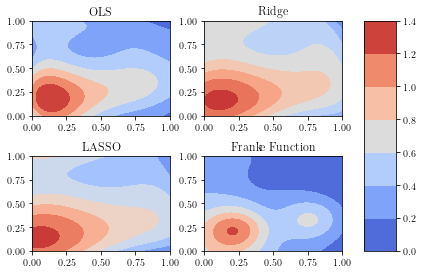

In [11]:
plt.subplot(221)
plt.contourf(x_plot_mesh, y_plot_mesh, z_predict_ols, cmap=cm.coolwarm)
plt.title("OLS")
plt.tight_layout()

plt.subplot(222)
plt.contourf(x_plot_mesh, y_plot_mesh, z_predict_ridge, cmap=cm.coolwarm)
plt.title("Ridge")
plt.tight_layout()

plt.subplot(223)
plt.contourf(x_plot_mesh, y_plot_mesh, z_predict_lasso, cmap=cm.coolwarm)
plt.title("LASSO")
plt.tight_layout()

plt.subplot(224)
plt.contourf(x_plot_mesh, y_plot_mesh, z_plot_franke, cmap=cm.coolwarm)
plt.title("Franke Function")
plt.tight_layout()


plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)

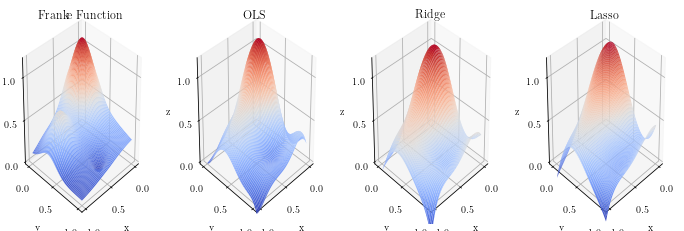

In [12]:
fig = plt.figure(figsize=(3 * 4,4))

# Plot the analytic curve
ax = fig.add_subplot(1, 4, 1, projection="3d")
ax.set_title("Franke Function")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([0, 1.2])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_plot_franke, cmap=cm.coolwarm)

# Plot the OLS prediction
ax = fig.add_subplot(1, 4, 2, projection="3d")
ax.set_title("OLS")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([0, 1.2])

surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_ols, cmap=cm.coolwarm)
# Plot the Ridge
ax = fig.add_subplot(1, 4, 3, projection="3d")
ax.set_title("Ridge")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([0, 1.2])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_ridge, cmap=cm.coolwarm)
# Plot the Lasso
ax = fig.add_subplot(1, 4, 4, projection="3d")
ax.set_title("Lasso")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([0, 1.2])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_lasso, cmap=cm.coolwarm)
